In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

import IPython.display as display
from IPython.display import clear_output
import PIL.Image


# **1. Import pretrained VGG16 and visualize its architecture**

VGG16 is a famous image classifier, that won the Imagenet challenge in 2014. It's one of the first deep CNN that achieved an amazing accuracy on this challenge. 
For more information: [VGG16 Paper](https://arxiv.org/pdf/1409.1556.pdf) 

In [2]:
# import pretrained weights 
conv_base = VGG16(weights = 'imagenet', include_top = False)
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

# **2. Method**

To visualize what convolutional filters learn to detect, we will follow a slightly different approach : **instead of having fixed input and wiggling weights to reduce a classification error, we will fix the weights and wiggle the input to maximize the average activation of a filter**. <br> The algorithm is then **gradient ascent** instead of gradient descent. <br>
In other words, the loss is now the average activation of a filter in a specific layer, and we want to maximize it by modifying the image in order to trigger the filter as much as possible. Then, by visualizing the image, we can have a good idea of what a filter detects.
<br>
The starting image will be a random noise array, that will hopefully allow us to visualize a pattern after being processed.

### **2.1 Convert from tensor to images and vis versa, generate random noise**

In [3]:
# PROCESS, UNPROCESS AND SHOW

def preprocess(img): 
  img = tf.cast(img, tf.float32)
  img = img/255.
  return img

def unprocess(img) : 
  img = img*255
  img = tf.cast(img, tf.uint8)
  return img

def show(img, figsize):
  plt.figure(figsize=figsize)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()


# CREATE RANDOM NOISE IMAGE

input_image = tf.random.uniform((150, 150, 3),maxval=255) 
input_img = tf.Variable(preprocess(input_image))

### **2.2 Use gradient ascent to excite filters**

In [5]:
def calc_loss(img, filter_index, extraction_model): 
  batch = tf.expand_dims(img, 0)
  layer_activation = extraction_model(batch, filter_index)
  loss = tf.reduce_mean(layer_activation[:,:,:, filter_index])
  return loss

# @tf.function decorator for efficiency purposes
#@tf.function 
def gradient_ascent_step(img, filter_index,learning_rate, extraction_model):
  with tf.GradientTape() as tape :
    loss = calc_loss(img, filter_index, extraction_model)
  gradients = tape.gradient(loss, img)
  gradients = gradients/(tf.math.reduce_std(gradients + 1e-8))
  img.assign_add(learning_rate*gradients) # gradient descent update
  img.assign(tf.clip_by_value(img, -1, 1)) # prevent exploding gradients in deep architectures


def get_excitation(image, filter_index, epochs, learning_rate,extraction_model):

    # Run gradient ascent for a given number of epochs
    for i in range(epochs) :
        gradient_ascent_step(image, filter_index, learning_rate, extraction_model)
        if i%2000 == 0 :
            print(i)
    # convert tensor into a classic image         
    return unprocess(image)


def generate_excitations(layer_name, filter_indices, epochs, learning_rate, figsize) : 
  excitations = np.zeros((500,500,3,len(filter_indices)))
  layer_output = conv_base.get_layer(layer_name).output
  extraction_model = tf.keras.Model(inputs=conv_base.input, outputs=layer_output)

  for i in range(len(filter_indices)) :
      input_image = tf.random.uniform((500, 500, 3),maxval=255) 
      image = tf.Variable(preprocess(input_image))
      excitations[:,:,:,i] = get_excitation(image, filter_indices[i], epochs, learning_rate, extraction_model)
      show(excitations[:,:,:,i], figsize)

  return excitations


# **3. Visualize some filters !**

We expect the first filters to detect simple textures, while deeper in the network, filters will be designed to detect more and more complex features ! 

0
200
400
600
800
1000
1200
1400
1600
1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


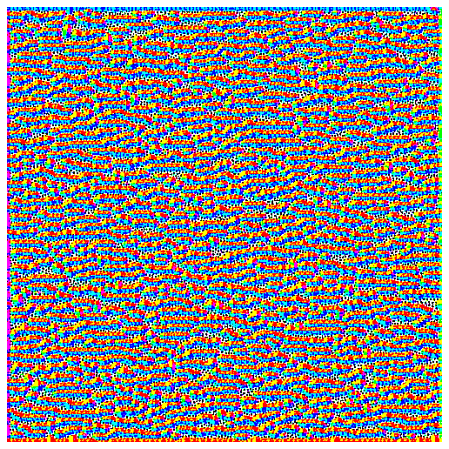

0
200
400
600
800
1000
1200
1400
1600
1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


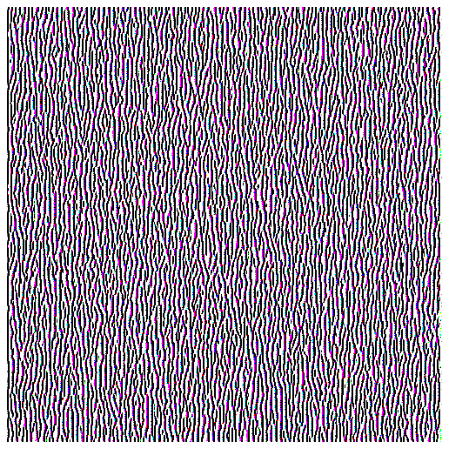

0
200
400
600
800
1000
1200
1400
1600
1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


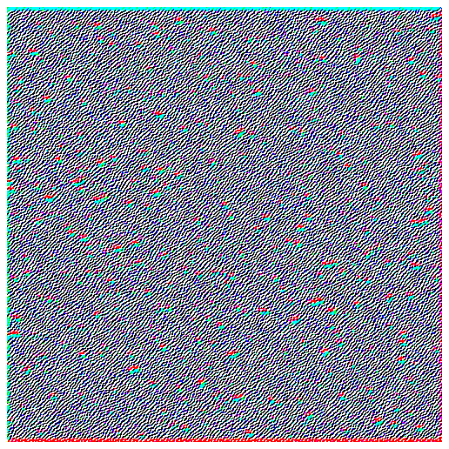

In [19]:
excitations = generate_excitations('block2_conv1',[3,34,58], 1000, 0.001, (8,8)) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


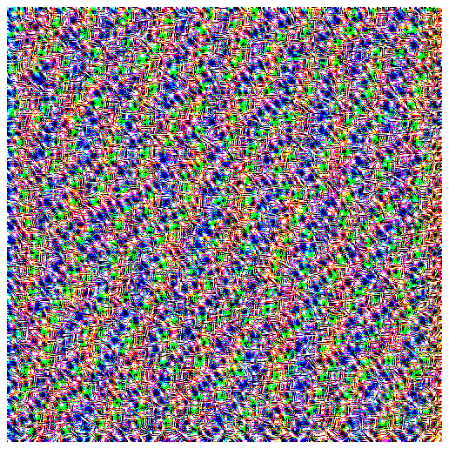

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


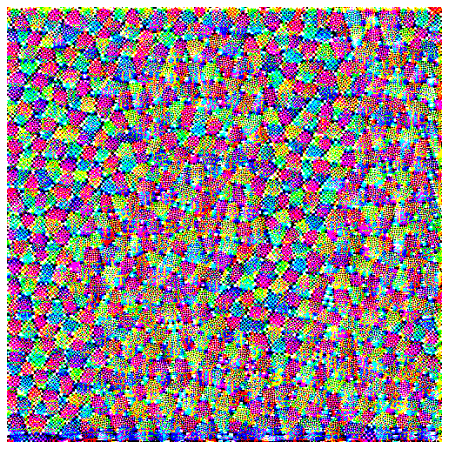

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


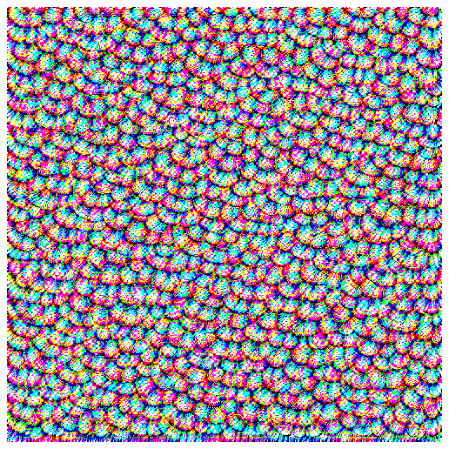

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


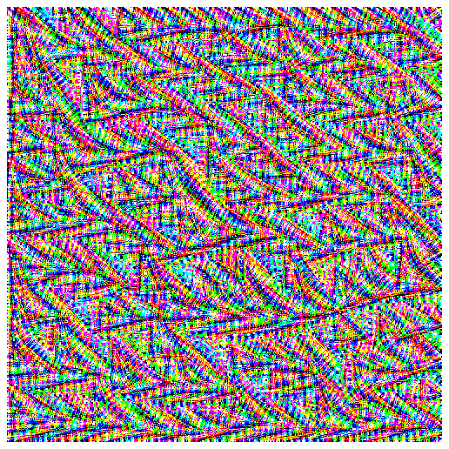

In [28]:
excitations = generate_excitations('block4_conv2',[400,410,430,500], 6000, 0.001, (8,8)) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


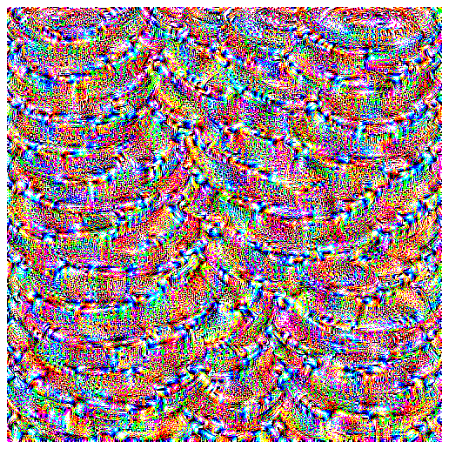

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


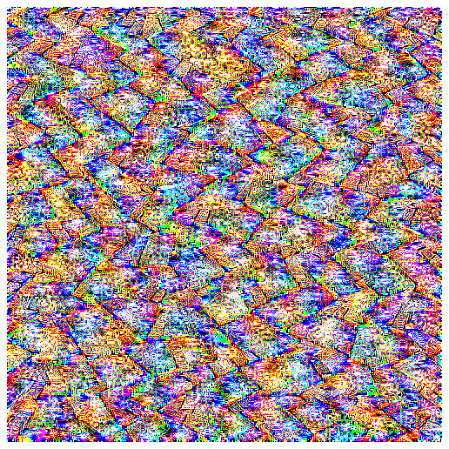

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


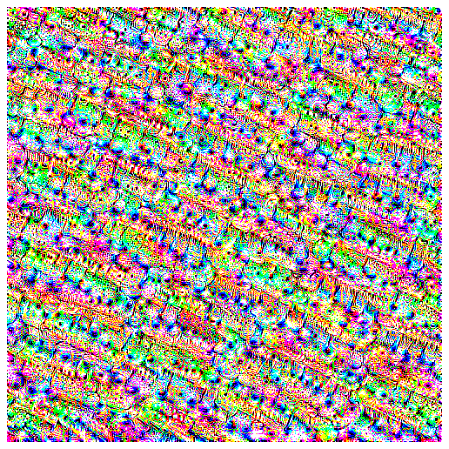

In [29]:
excitations = generate_excitations('block5_conv3',[3,34,58], 6000, 0.001, (8,8)) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


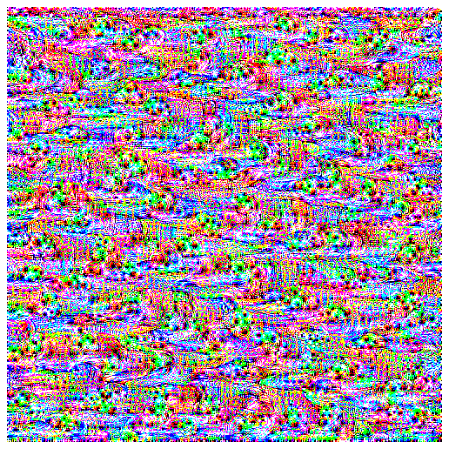

In [27]:
excitations = generate_excitations('block5_conv3',[500], 6000, 0.001, (8,8)) 